In [104]:
import argparse, sys, shutil, glob, os
from pathlib import Path
from itertools import combinations
from datetime import datetime

import numpy as np
import pandas as pd
import arviz as az
# from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.special import expit, logit
from tqdm import tqdm
import pickle
# import pystan
# import stan


# 1) Load your saved .nc

In [105]:
import arviz as az
from pathlib import Path

nc_path = "stan_out/rlddm_single_subject-20250924_203946.nc"  # <- your file
idata = az.from_netcdf(nc_path)


# 2) Quick sanity: R-hat / ESS

In [106]:
az.summary(idata, var_names=["alpha","a","t0","scaler", "log_scaler"], hdi_prob=0.95)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.488,0.151,0.218,0.788,0.002,0.002,4056.0,2659.0,1.0
a,1.565,0.037,1.491,1.638,0.001,0.001,3153.0,2291.0,1.0
t0,0.282,0.006,0.271,0.293,0.000,0.000,3413.0,2636.0,1.0
scaler,0.058,0.014,0.035,0.088,0.000,0.000,3742.0,2438.0,1.0
log_scaler,-2.875,0.237,-3.306,-2.389,0.004,0.004,3742.0,2438.0,1.0


# 3) Correlations among parameters (all draws)

In [107]:
post = az.extract(idata, var_names=["alpha","a","t0","scaler", "log_scaler"], combined=True).to_pandas()
post.corr()


,alpha,a,t0,scaler,log_scaler,chain,draw
alpha,1.000000,-0.009865,0.018009,-0.023248,-0.022188,-2.063717e-02,1.487377e-02
a,-0.009865,1.000000,-0.309701,0.022408,0.019711,-3.855945e-03,1.887704e-03
t0,0.018009,-0.309701,1.000000,-0.011466,-0.012211,-2.029541e-02,-5.985321e-03
scaler,-0.023248,0.022408,-0.011466,1.000000,0.987366,2.374068e-02,-1.336046e-02
log_scaler,-0.022188,0.019711,-0.012211,0.987366,1.000000,2.101323e-02,-8.289098e-03
chain,-0.020637,-0.003856,-0.020295,0.023741,0.021013,1.000000e+00,-1.756362e-16
draw,0.014874,0.001888,-0.005985,-0.013360,-0.008289,-1.756362e-16,1.000000e+00


# 4) Correlations with divergent draws removed

In [108]:
# boolean mask of divergent transitions aligned to combined draws
div = idata.sample_stats["diverging"].stack(sample=("chain","draw")).values.astype(bool)
post_ok = post[~div]
post_ok.corr()


,alpha,a,t0,scaler,log_scaler,chain,draw
alpha,1.000000,-0.009865,0.018009,-0.023248,-0.022188,-2.063717e-02,1.487377e-02
a,-0.009865,1.000000,-0.309701,0.022408,0.019711,-3.855945e-03,1.887704e-03
t0,0.018009,-0.309701,1.000000,-0.011466,-0.012211,-2.029541e-02,-5.985321e-03
scaler,-0.023248,0.022408,-0.011466,1.000000,0.987366,2.374068e-02,-1.336046e-02
log_scaler,-0.022188,0.019711,-0.012211,0.987366,1.000000,2.101323e-02,-8.289098e-03
chain,-0.020637,-0.003856,-0.020295,0.023741,0.021013,1.000000e+00,-1.756362e-16
draw,0.014874,0.001888,-0.005985,-0.013360,-0.008289,-1.756362e-16,1.000000e+00


# 5) Helpful plots (optional)

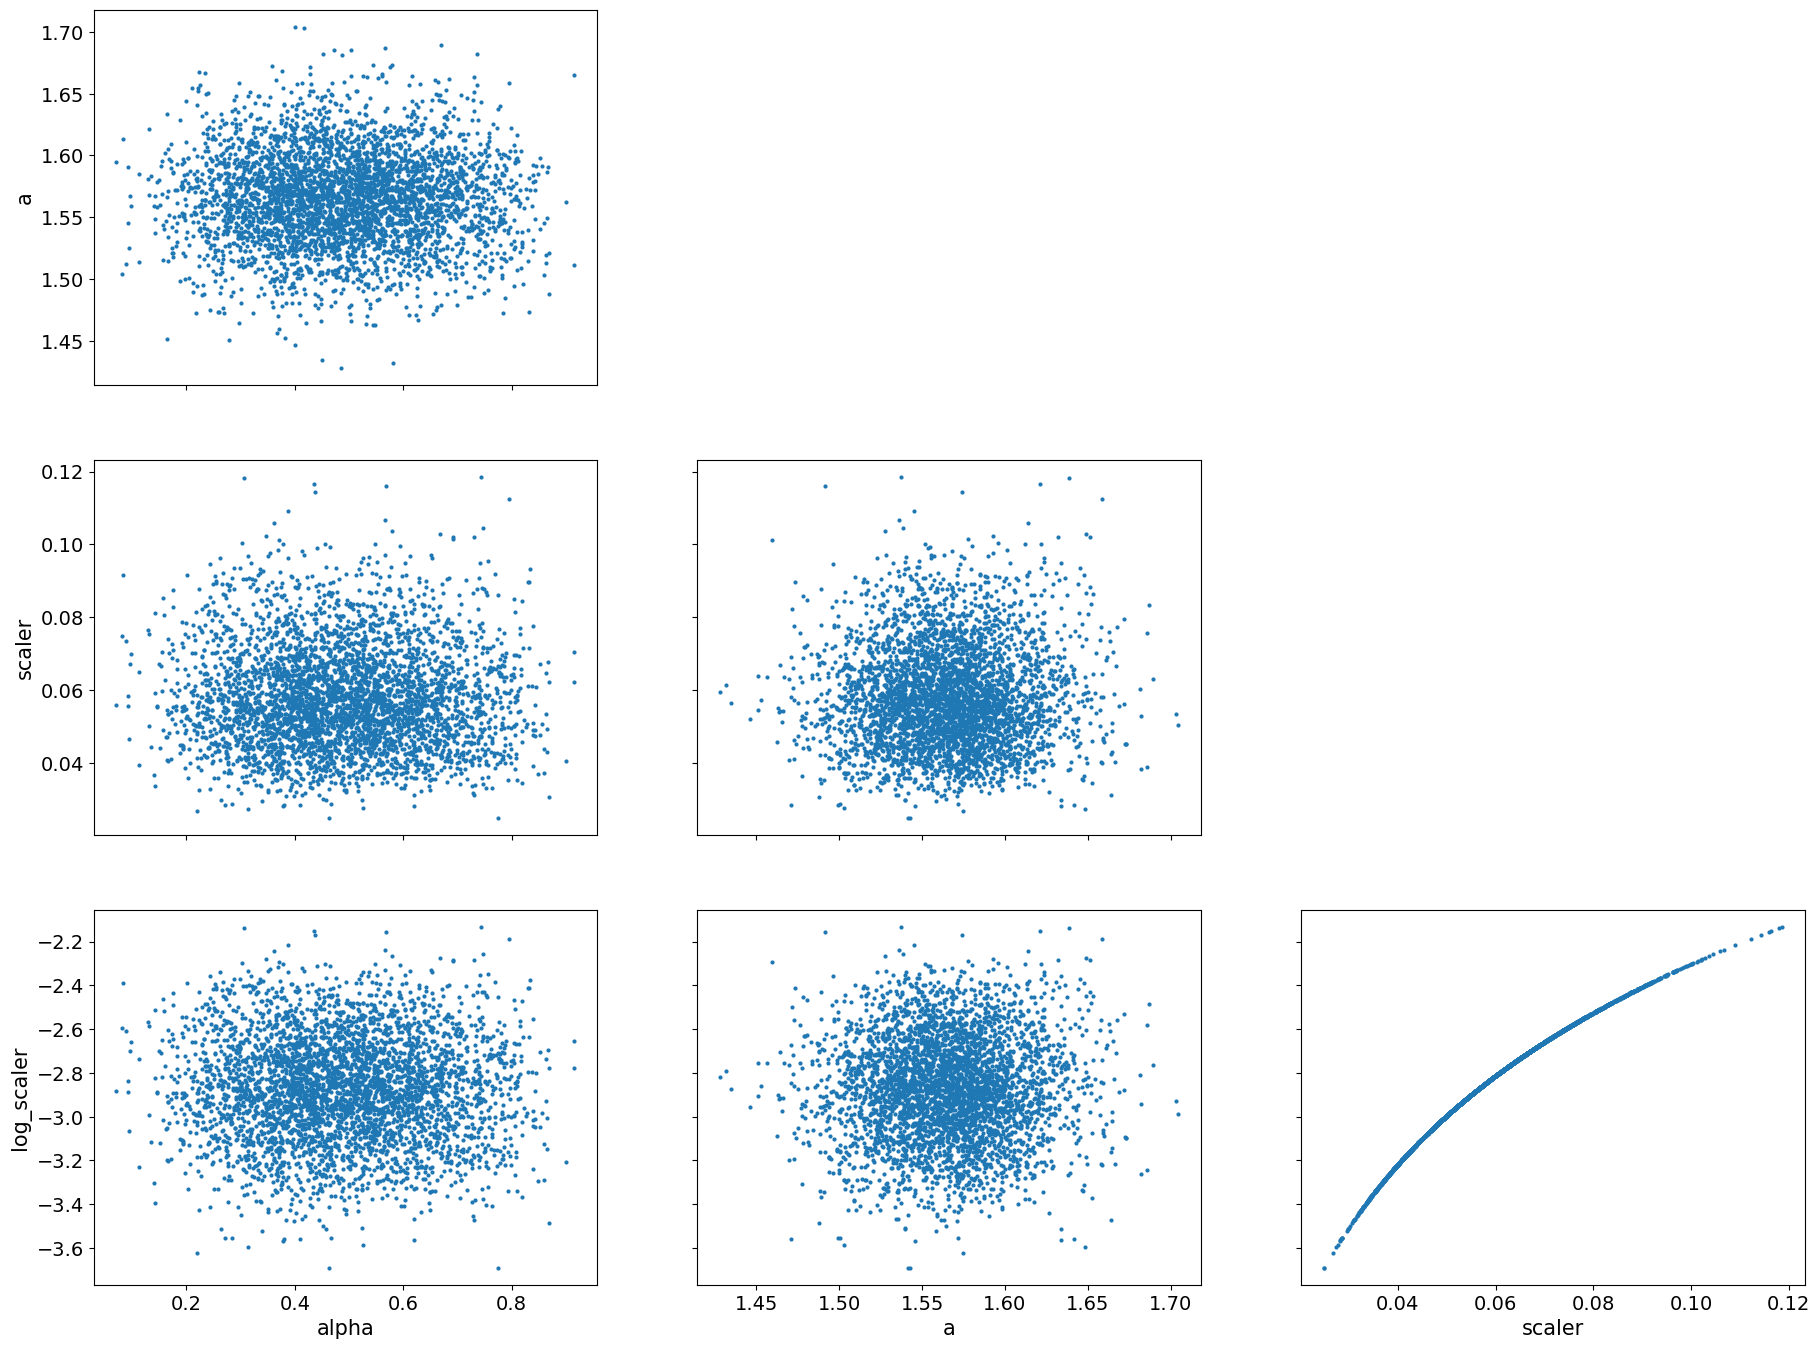

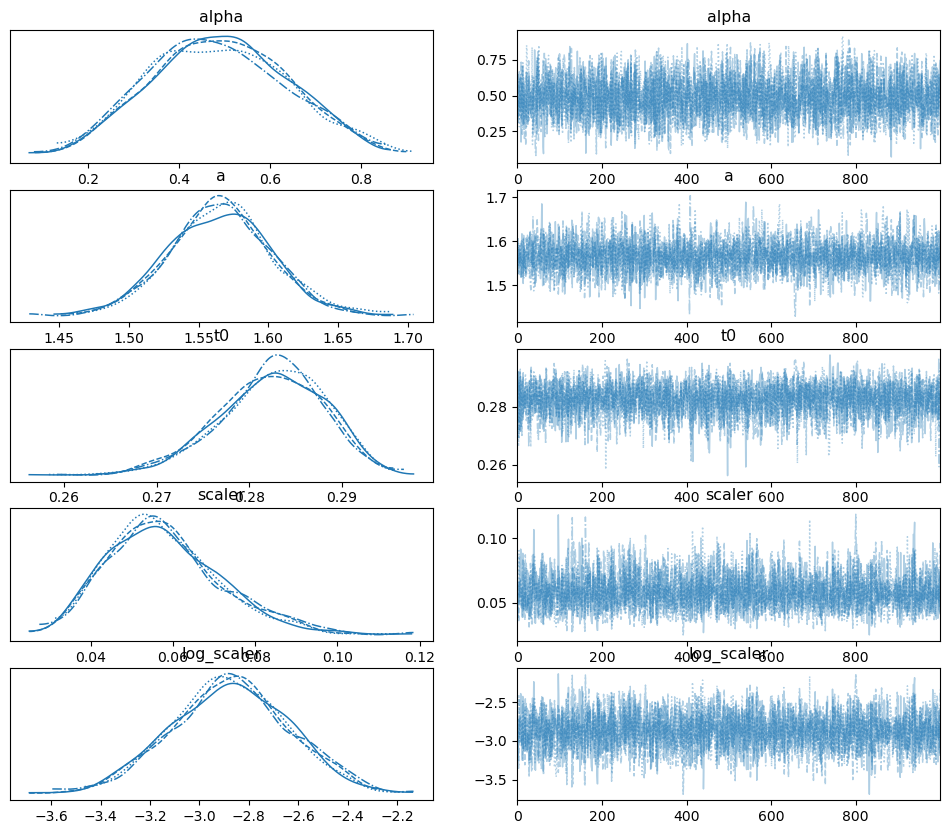

In [109]:
az.plot_pair(idata, var_names=["alpha","a","scaler", "log_scaler"], kind="scatter", divergences=True);
az.plot_trace(idata, var_names=["alpha","a","t0","scaler", "log_scaler"]);

# 6) Count divergences, max treedepth, etc.

In [110]:
print(int(idata.sample_stats["diverging"].sum()),
int((idata.sample_stats["tree_depth"] == idata.sample_stats["tree_depth"].max()).sum()))


0 1302
